# Schrodinger FCNN PyTorch

This notebook contains the code originally from the Python script `schrodinger_FCNN_pytorch.py`.

**Project Goal:** Use a Fully Connected Neural Network (FCNN) in PyTorch to predict the ground state wavefunction of the 1D Schrodinger equation.

**Important:**
1.  Ensure you have placed the necessary data file (e.g., `NN_valid_data_schrodinger_1D_sol-Rx=3-Nx=128-num_data=25000-size_data=129.csv`) in the `../data/` directory relative to this notebook.
2.  Create an `../outputs/` directory relative to this notebook. The training results (model files, plots) will be saved there.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import timeit
import csv
import os
import math

In [7]:
class SchrodingerFCNN(nn.Module): # Renamed from MLP
    """
    PyTorch implementation of a FCNN for predicting Schrodinger equation wavefunctions.
    Uses nn.Linear layers and Softplus activation.
    """
    def __init__(self, input_size, hidden_sizes, output_size):
        super(SchrodingerFCNN, self).__init__()
        self.layers = nn.ModuleList()
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        # Dynamically create layers based on hidden_sizes list
        for i in range(len(layer_sizes) - 1):
            # Note: Bias is True by default in nn.Linear
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            # Add activation except for the last layer
            if i < len(layer_sizes) - 2:
                self.layers.append(nn.Softplus()) # Using Softplus as in the original code

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [12]:
class SchrodingerFCNNTrainer: # Renamed from MLPTrainer
    """
    Handles data loading, training (manual batching), evaluation, and plotting
    for the SchrodingerFCNN model. Assumes notebook is in 'notebooks/' and data/outputs are one level up.
    """
    def __init__(self,
                 # Data parameters
                 Rx=3, Nx=128,
                 all_data=8000,
                 data_path_prefix='../data', # Relative path from notebooks/
                 output_path_prefix='../outputs', # Relative path from notebooks/
                 data_file_name_template='NN_valid_data_schrodinger_1D_sol-Rx={Rx}-Nx={Nx}-num_data={num_data}-size_data={size_data}.csv',
                 num_data_in_filename=25000,
                 # Model architecture parameters
                 hidden_sizes=[128],
                 # Training parameters
                 batch_size=200,
                 learning_rate=0.01,
                 epochnum=200,
                 weight_decay=1e-4,
                 shuffle_each_epoch=True, # Added shuffle option
                 early_stopping_patience=10): # Added patience

        self.Rx = Rx
        self.Nx = Nx
        self.data_size = Nx - 1         # Input size (potential grid points)
        self.output_neuron = Nx - 1     # Output size (wavefunction grid points)
        self.hidden_sizes = hidden_sizes
        self.all_data_to_use = all_data # Use only this many samples
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochnum = epochnum
        self.weight_decay = weight_decay
        self.data_path_prefix = data_path_prefix
        self.output_path_prefix = output_path_prefix # Store output path
        self.shuffle_each_epoch = shuffle_each_epoch # Store shuffle preference
        self.early_stopping_patience = early_stopping_patience

        # Ensure output directory exists
        os.makedirs(self.output_path_prefix, exist_ok=True)
        print(f"Outputs will be saved to: {os.path.abspath(self.output_path_prefix)}")

        # Construct filename
        size_data_in_filename = self.Nx + 1 # This seems to be the convention in the filename
        self.data_file_name = data_file_name_template.format(
            Rx=self.Rx, Nx=self.Nx, num_data=num_data_in_filename, size_data=size_data_in_filename
        )
        self.data_full_path = os.path.join(self.data_path_prefix, self.data_file_name) # Use prefix
        print(f"Attempting to load data from: {os.path.abspath(self.data_full_path)}")


        self.dx = 2 * self.Rx / self.Nx
        # Define x points for plotting
        self.x = np.linspace(-self.Rx + self.dx/2, self.Rx - self.dx/2, self.Nx - 1)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self._load_data() # Load data during initialization

        # Initialize model
        self.model = SchrodingerFCNN(
            input_size=self.data_size,
            hidden_sizes=self.hidden_sizes,
            output_size=self.output_neuron
        ).to(self.device)

        print("\nModel Architecture:")
        print(self.model)

        # Optimizer and Loss
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        self.criterion = nn.MSELoss(reduction='mean') # Use mean reduction for consistent scaling


    def _load_data(self):
        """Loads data, processes, splits into tensors (no DataLoaders)."""
        print(f"Loading data from: {self.data_full_path}")

        try:
            with open(self.data_full_path, newline='') as csvfile:
                dataconfig = list(csv.reader(csvfile))
                dataconfig = np.array(dataconfig, dtype="float32")
        except FileNotFoundError:
            print(f"Error: Data file not found at {self.data_full_path}")
            print(f"Please ensure the data file exists in the '{self.data_path_prefix}' directory relative to where you run this notebook.")
            raise
        except Exception as e:
            print(f"Error loading or parsing data: {e}")
            raise

        # Determine column indices based on Nx
        # Assuming format: E_0, V(x_1)...V(x_{Nx-1}), psi_0, psi(x_1)...psi(x_{Nx-1})
        # Total columns = 1 (E_0) + (Nx-1) (V) + 1 (psi_0) + (Nx-1) (psi) = 2*Nx
        # Potential: Column 1 to Nx-1 (0-based index: 1 to Nx-1) -> Nx-1 columns
        # Wave func: Column Nx+1 to 2*Nx-1 (0-based index: Nx+1 to 2*Nx-1) -> Nx-1 columns
        potential_start_col = 1
        potential_end_col = self.Nx # Exclusive index
        fnum_start_col = self.Nx + 1 # +1 because psi_0 is at Nx
        fnum_end_col = 2 * self.Nx   # Exclusive index

        potential_raw = dataconfig[:self.all_data_to_use, potential_start_col:potential_end_col]
        fnum_raw = dataconfig[:self.all_data_to_use, fnum_start_col:fnum_end_col]

        # --- Shape Validation ---
        if potential_raw.shape[1] != self.data_size:
             raise ValueError(f"Potential data width ({potential_raw.shape[1]}) != expected input size ({self.data_size})")
        if fnum_raw.shape[1] != self.output_neuron:
             raise ValueError(f"Wavefunction data width ({fnum_raw.shape[1]}) != expected output size ({self.output_neuron})")
        if potential_raw.shape[0] < self.all_data_to_use:
            print(f"Warning: Loaded fewer samples ({potential_raw.shape[0]}) than requested ({self.all_data_to_use}). Using available samples.")
            self.all_data_to_use = potential_raw.shape[0]
            if self.all_data_to_use == 0:
                 raise ValueError("No data samples loaded.")
        # --- End Shape Validation ---


        # Convert to tensors
        potential_all = torch.from_numpy(potential_raw).float()
        fnum_all = torch.from_numpy(fnum_raw).float()

        # Split data: 60% train, 20% validation, 20% test
        total_samples = potential_all.shape[0]
        self.training_data_count = int(total_samples * 0.60)
        self.validation_data_count = int(total_samples * 0.20)
        self.test_data_count = total_samples - self.training_data_count - self.validation_data_count

        # Ensure counts add up and adjust test count if necessary due to rounding
        if self.training_data_count + self.validation_data_count + self.test_data_count != total_samples:
             self.test_data_count = total_samples - self.training_data_count - self.validation_data_count

        train_end_idx = self.training_data_count
        val_end_idx = self.training_data_count + self.validation_data_count

        # Slice tensors
        self.potential_train = potential_all[:train_end_idx]
        self.fnum_train = fnum_all[:train_end_idx]
        self.potential_validation = potential_all[train_end_idx:val_end_idx]
        self.fnum_validation = fnum_all[train_end_idx:val_end_idx]
        self.potential_test = potential_all[val_end_idx:]
        self.fnum_test = fnum_all[val_end_idx:]

        # Update counts just in case slicing resulted in different sizes (shouldn't happen)
        self.training_data_count = self.potential_train.shape[0]
        self.validation_data_count = self.potential_validation.shape[0]
        self.test_data_count = self.potential_test.shape[0]

        print(f"Data loaded successfully:")
        print(f"  Training samples:   {self.training_data_count}")
        print(f"  Validation samples: {self.validation_data_count}")
        print(f"  Testing samples:    {self.test_data_count}")


    def calculate_loss(self, f_pred, f_target):
        """Calculates the scaled loss."""
        # Raw MSE Loss
        mse_loss = self.criterion(f_pred, f_target)
        # Scale the loss as done in the original script
        # loss = dx * sum( (pred - target)^2 )
        # mse_loss = sum( (pred - target)^2 ) / N
        # => sum( (pred - target)^2 ) = mse_loss * N
        # => scaled_loss = dx * mse_loss * N
        scaled_loss = self.dx * mse_loss * self.output_neuron # N is output_neuron size
        return scaled_loss

    def train_one_epoch(self, current_epoch_indices):
        """Performs a single training epoch using manual batch slicing."""
        self.model.train() # Set model to training mode
        running_loss = 0.0
        samples_processed = 0
        num_batches = (self.training_data_count + self.batch_size - 1) // self.batch_size # Calculate total batches

        # Iterate through training data using indices for this epoch
        for i in range(0, self.training_data_count, self.batch_size):
            batch_indices = current_epoch_indices[i:min(i + self.batch_size, self.training_data_count)]
            if len(batch_indices) == 0: continue # Skip if indices are empty

            # Get batch data using indices
            batch_potential = self.potential_train[batch_indices].to(self.device)
            batch_fnum = self.fnum_train[batch_indices].to(self.device)

            current_batch_size = len(batch_indices)
            samples_processed += current_batch_size

            # Forward pass
            f_pred = self.model(batch_potential)
            loss = self.calculate_loss(f_pred, batch_fnum)

            # Backward pass and optimization
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Accumulate loss (weighted by batch size)
            running_loss += loss.item() * current_batch_size

            # Optional: Print batch progress (commented out for cleaner notebook)
            # current_batch_num = (i // self.batch_size) + 1
            # print(f'  Batch {current_batch_num}/{num_batches} - Loss: {loss.item():.3f}')

        # Calculate average loss for the epoch
        avg_epoch_loss = running_loss / samples_processed if samples_processed > 0 else 0
        return avg_epoch_loss, samples_processed


    def evaluate(self, potential_set, fnum_set, data_count):
        """Evaluates the model on a given data set (test or validation)."""
        self.model.eval() # Set model to evaluation mode
        total_loss = 0.0
        num_samples = 0
        if data_count == 0:
             print("Warning: Attempting to evaluate on an empty dataset.")
             return float('inf') # Or 0, depending on desired behavior

        with torch.no_grad(): # Disable gradient calculations
            for i in range(0, data_count, self.batch_size):
                end_idx = min(i + self.batch_size, data_count)
                if i >= end_idx: continue # Should not happen with correct logic

                # Get batch data
                batch_potential = potential_set[i:end_idx].to(self.device)
                batch_fnum = fnum_set[i:end_idx].to(self.device)

                current_batch_size = len(batch_potential)
                if current_batch_size == 0: continue

                # Forward pass
                f_pred = self.model(batch_potential)
                loss = self.calculate_loss(f_pred, batch_fnum)

                # Accumulate loss
                total_loss += loss.item() * current_batch_size
                num_samples += current_batch_size

        # Calculate average loss
        avg_loss_per_sample = total_loss / num_samples if num_samples > 0 else float('inf')
        self.model.train() # Set model back to training mode
        return avg_loss_per_sample

    def train(self):
        """Main training loop over multiple epochs."""
        print("\n--- Starting Training ---")
        epoch_train_losses = []
        epoch_valid_losses = []
        best_valid_loss = float('inf')
        epochs_no_improve = 0
        best_model_state = None
        early_stop_triggered = False
        start_time = timeit.default_timer()

        indices = torch.arange(self.training_data_count) # Base indices

        for epoch in range(self.epochnum):
            # Shuffle indices for the current epoch if enabled
            if self.shuffle_each_epoch:
                epoch_indices = indices[torch.randperm(self.training_data_count)]
            else:
                epoch_indices = indices

            # Train one epoch
            avg_train_loss, samples_in_epoch = self.train_one_epoch(epoch_indices)
            epoch_train_losses.append(avg_train_loss)

            # Evaluate on validation set
            avg_valid_loss = self.evaluate(self.potential_validation, self.fnum_validation, self.validation_data_count)
            epoch_valid_losses.append(avg_valid_loss)
            print(f"Epoch {epoch+1}/{self.epochnum} complete. "
                  f"Avg Training Loss: {avg_train_loss:.3f} | "
                  f"Avg Validation Loss: {avg_valid_loss:.3f}")

            # Early Stopping Check
            if avg_valid_loss < best_valid_loss:
                best_valid_loss = avg_valid_loss
                epochs_no_improve = 0
                best_model_state = self.model.state_dict() # Save the best state
                # print(f"  (New best validation loss: {best_valid_loss:.3f}. Saving model state)") # Verbose
            else:
                epochs_no_improve += 1
                # print(f"  (Validation loss did not improve for {epochs_no_improve} epoch(s))") # Verbose
                if epochs_no_improve >= self.early_stopping_patience:
                    print(f"\n\nEarly stopping triggered after {epoch+1} epochs.")
                    early_stop_triggered = True
                    break # Exit training loop

        stop_time = timeit.default_timer()
        total_time = stop_time - start_time

        # Determine which model state to use and save
        save_suffix = ""
        if early_stop_triggered and best_model_state is not None:
             print("\nLoading best model state from early stopping.")
             self.model.load_state_dict(best_model_state)
             save_suffix = '_best'
        else:
             # If no early stopping or best state wasn't saved (shouldn't happen), save final state
             print("\nUsing final model state from last epoch.")
             save_suffix = '_final'


        print(f"\n--- Training Finished ---")
        print(f"Total Training time: {total_time:.2f} seconds")

        # Plot losses
        self._plot_loss(epoch_train_losses, epoch_valid_losses)

        # Final evaluation on test set using the chosen model state
        final_test_loss = self.evaluate(self.potential_test, self.fnum_test, self.test_data_count)
        print(f"\nFinal Test Loss (using {'best' if early_stop_triggered and best_model_state is not None else 'final'} model): {final_test_loss:.3f}")

        # Plot some predictions
        self._plot_predictions(num_plots=5)

        # Save the chosen model state
        self.save_model(suffix=save_suffix)


    def _plot_loss(self, epoch_train_losses, epoch_valid_losses):
        """Plots the average training and validation loss per epoch."""
        print("\n--- Plotting Training and Validation Loss ---")
        plt.figure(figsize=(10, 6))
        num_epochs_recorded = len(epoch_train_losses)
        epochs_range = range(1, num_epochs_recorded + 1)
        plt.plot(epochs_range, epoch_train_losses, marker='o', linestyle='-', label='Training Loss')
        plt.plot(epochs_range, epoch_valid_losses, marker='x', linestyle='--', label='Validation Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.yscale('log') # Use log scale for better visualization if losses vary widely
        plt.grid(True, which="both", ls="--", alpha=0.6)
        plt.legend()
        plt.tight_layout()
        save_path = os.path.join(self.output_path_prefix, 'fcnn_train_validation_loss.png') # Use prefix
        plt.savefig(save_path)
        print(f"Saved loss plot to {save_path}")
        plt.show() # Display plot in notebook
        plt.close() # Close the figure


    def _plot_predictions(self, num_plots=5):
        """Plots model predictions against target values for a few test samples."""
        print(f"\n--- Plotting {num_plots} Test Predictions ---")
        self.model.eval() # Ensure model is in eval mode

        if self.test_data_count < num_plots:
            print(f"Warning: Requested {num_plots} plots, but only {self.test_data_count} test samples available. Plotting all.")
            num_plots = self.test_data_count
        if num_plots <= 0:
             print("No test samples to plot.")
             return

        # Select indices evenly spaced across the test set
        plot_indices = np.linspace(0, self.test_data_count - 1, num_plots, dtype=int)

        with torch.no_grad(): # Disable gradient calculations for plotting
            for i, sample_idx_in_test_set in enumerate(plot_indices):
                # Get data for the specific sample
                potential_sample_tensor = self.potential_test[sample_idx_in_test_set].unsqueeze(0).to(self.device) # Add batch dim
                fnum_target_numpy = self.fnum_test[sample_idx_in_test_set].cpu().numpy()
                potential_input_numpy = self.potential_test[sample_idx_in_test_set].cpu().numpy()

                # Make prediction
                f_pred_tensor = self.model(potential_sample_tensor)
                f_pred_numpy = f_pred_tensor.squeeze(0).cpu().numpy() # Remove batch dim

                # Calculate loss for this specific sample
                loss_sample = self.calculate_loss(f_pred_tensor,
                                                  self.fnum_test[sample_idx_in_test_set].unsqueeze(0).to(self.device)).item()

                # --- Plotting ---
                fig, ax1 = plt.subplots(dpi=120) # Create figure and primary axis for wavefunction

                # Plot wavefunction (Predicted vs Target)
                ax1.plot(self.x, f_pred_numpy, color='blue', linewidth=2, label=r'Predicted $\psi(x)$')
                ax1.plot(self.x, fnum_target_numpy, color='red', linestyle='--', label=r'Target $\psi(x)$')
                ax1.set_xlabel(r'$x$')
                ax1.set_ylabel(r'$\psi(x)$', color='black')
                ax1.tick_params(axis='y', labelcolor='black')
                ax1.grid(True, linestyle='--', alpha=0.6)

                # Create secondary axis for potential
                ax2 = ax1.twinx()
                ax2.plot(self.x, potential_input_numpy, color='green', linestyle=':', alpha=0.7, label='Potential V(x)')
                ax2.set_ylabel('Potential V(x)', color='green')
                ax2.tick_params(axis='y', labelcolor='green')

                # Combine legends
                lines1, labels1 = ax1.get_legend_handles_labels()
                lines2, labels2 = ax2.get_legend_handles_labels()
                ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

                # Calculate original index in the full dataset
                full_data_index = self.training_data_count + self.validation_data_count + sample_idx_in_test_set
                ax1.set_title(f'FCNN Test Sample (Full Idx: {full_data_index}) | Loss: {loss_sample:.4f}')

                # Save and show plot
                plot_filename = os.path.join(self.output_path_prefix, f'fcnn_prediction_sample_{full_data_index}.png') # Use prefix
                plt.savefig(plot_filename)
                print(f"Saved prediction plot to {plot_filename}")
                plt.show() # Display plot in notebook
                plt.close(fig) # Close the figure to free memory



    def save_model(self, base_filename="schrodinger_fcnn_model", suffix="_final"):
        """Saves the model's state dictionary."""
        try:
            filename = os.path.join(self.output_path_prefix, f"{base_filename}{suffix}.pth") # Use prefix
            torch.save(self.model.state_dict(), filename)
            print(f"Model state dictionary saved successfully to {filename}")
        except Exception as e:
            print(f"Error saving model state: {e}")

Outputs will be saved to: /Users/wanghongxun/CascadeProjects/machine_learning_schorodinger/outputs
Attempting to load data from: /Users/wanghongxun/CascadeProjects/machine_learning_schorodinger/data/NN_valid_data_schrodinger_1D_sol-Rx=3-Nx=128-num_data=25000-size_data=129.csv
Using device: cpu
Loading data from: ../data/NN_valid_data_schrodinger_1D_sol-Rx=3-Nx=128-num_data=25000-size_data=129.csv
Data loaded successfully:
  Training samples:   4800
  Validation samples: 1600
  Testing samples:    1600

Model Architecture:
SchrodingerFCNN(
  (layers): ModuleList(
    (0): Linear(in_features=127, out_features=128, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=128, out_features=127, bias=True)
  )
)

--- Starting Training ---
Epoch 1/500 complete. Avg Training Loss: 0.272 | Avg Validation Loss: 0.095
Epoch 2/500 complete. Avg Training Loss: 0.053 | Avg Val

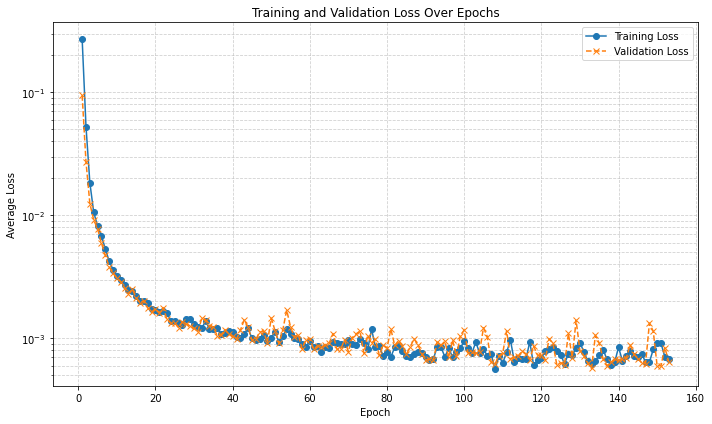


Final Test Loss (using best model): 0.001

--- Plotting 5 Test Predictions ---
Saved prediction plot to ../outputs/fcnn_prediction_sample_6400.png


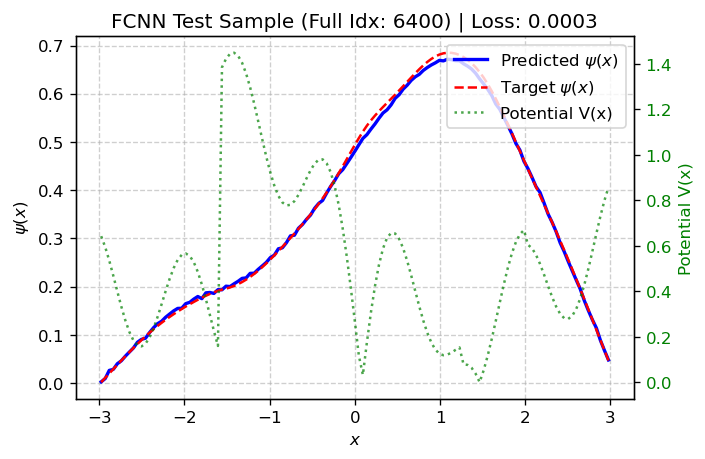

Saved prediction plot to ../outputs/fcnn_prediction_sample_6799.png


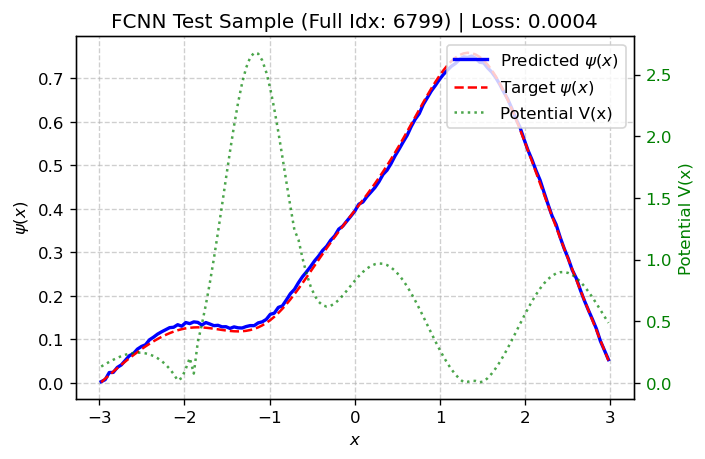

Saved prediction plot to ../outputs/fcnn_prediction_sample_7199.png


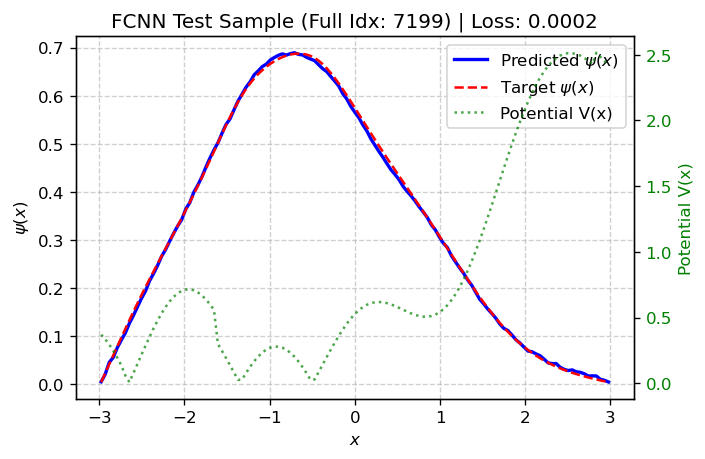

Saved prediction plot to ../outputs/fcnn_prediction_sample_7599.png


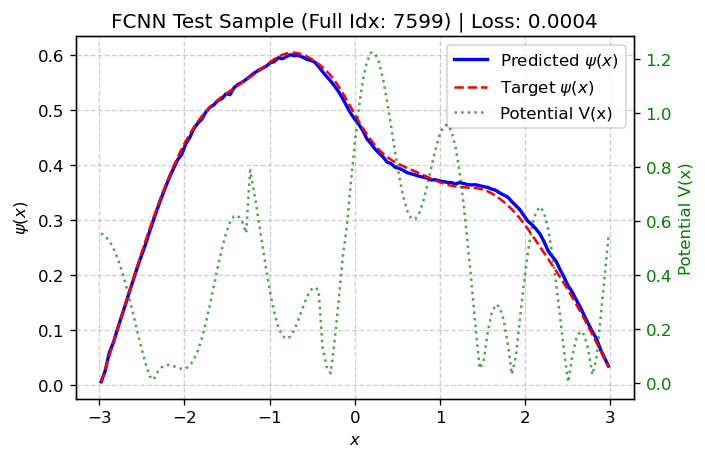

Saved prediction plot to ../outputs/fcnn_prediction_sample_7999.png


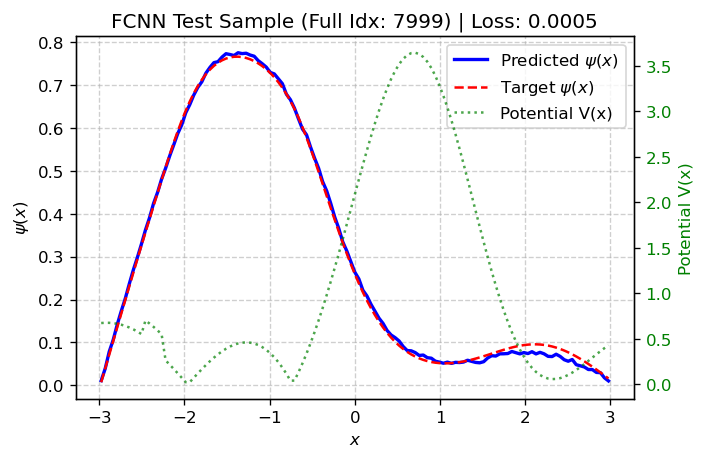

Model state dictionary saved successfully to ../outputs/schrodinger_fcnn_model_best.pth

--- Notebook Execution Complete ---


In [14]:
# --- Configuration ---
# Adjust these parameters as needed

# Data Parameters (Match your data file and desired subset)
PARAMS = {
    "Rx": 3,
    "Nx": 128,
    "all_data": 8000, # How many total samples to load and split
    "num_data_in_filename": 25000, # Value used in the data filename string
    "data_path_prefix": '../data', # Path to data directory (relative to notebook)
    "output_path_prefix": '../outputs', # Path to output directory (relative to notebook)
}

# Model Hyperparameters
MODEL_PARAMS = {
    "hidden_sizes": [128, 128], # Example: two hidden layers
}

# Training Hyperparameters
TRAIN_PARAMS = {
    "batch_size": 200,
    "learning_rate": 0.005, # Adjusted learning rate
    "epochnum": 500,       # Increased epochs
    "weight_decay": 1e-5,   # Adjusted weight decay
    "shuffle_each_epoch": True,
    "early_stopping_patience": 20 # Increased patience
}

# --- Execution ---

# Create the trainer instance with combined parameters
trainer = SchrodingerFCNNTrainer(
    **PARAMS,           # Unpack data parameters
    **MODEL_PARAMS,     # Unpack model parameters
    **TRAIN_PARAMS      # Unpack training parameters
)

# Start the training process
trainer.train()

print("\n--- Notebook Execution Complete ---")